<a href="https://colab.research.google.com/github/eligugliotta/tarc/blob/master/Multinomial_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from scipy.stats import norm

In [ ]:
# Carica i dati dal file CSV
data = pd.read_csv('/content/dati_analisi.tsv', encoding='utf-8', sep="\t")
columns = ['CODE', 'AGE_RANGE', 'GOVERNORATE', 'TYPE', 'GENDER']
data = data[[x for x in data[columns]]]

# Filtra gli '<eos>' da tutte le colonne
data = data.loc[~data[columns].isin(['<eos>']).any(axis=1)]
data = data.loc[~data[columns].isin(['Texas']).any(axis=1)]
print(data)

# Crea la tabella riepilogativa dei label per colonna
table = pd.DataFrame(columns=['Colonna', 'Label', 'Occorrenze'])

# Calcola le occorrenze per ogni label nelle colonne del DataFrame
for col in data.columns:
    labels = set(data[col])
    label_counts = [len(data[data[col] == label]) for label in labels]
    col_data = pd.DataFrame({'Colonna': [col] * len(labels),
                             'Label': list(labels),
                             'Occorrenze': label_counts})
    table = pd.concat([table, col_data], ignore_index=True)

# Stampa la tabella riepilogativa
print(table)
dataOriginal = data

          CODE AGE_RANGE GOVERNORATE   TYPE GENDER
0      arabizi     25-35       Tunis  forum      F
1      arabizi     25-35       Tunis  forum      F
2      arabizi     25-35       Tunis  forum      F
3      arabizi     25-35       Tunis  forum      F
4      arabizi     25-35       Tunis  forum      F
...        ...       ...         ...    ...    ...
23350  foreign     25-35       Tunis   blog      M
23351  foreign     25-35       Tunis   blog      M
23352  foreign     25-35       Tunis   blog      M
23353  foreign     25-35       Tunis   blog      M
23354  foreign     25-35       Tunis   blog      M

[20248 rows x 5 columns]
        Colonna     Label Occorrenze
0          CODE    emotag        468
1          CODE   foreign       3469
2          CODE   arabizi      16311
3     AGE_RANGE       -25       2907
4     AGE_RANGE         /       1731
5     AGE_RANGE     35-50       2250
6     AGE_RANGE     25-35      12898
7     AGE_RANGE       50+        462
8   GOVERNORATE     Tunis    

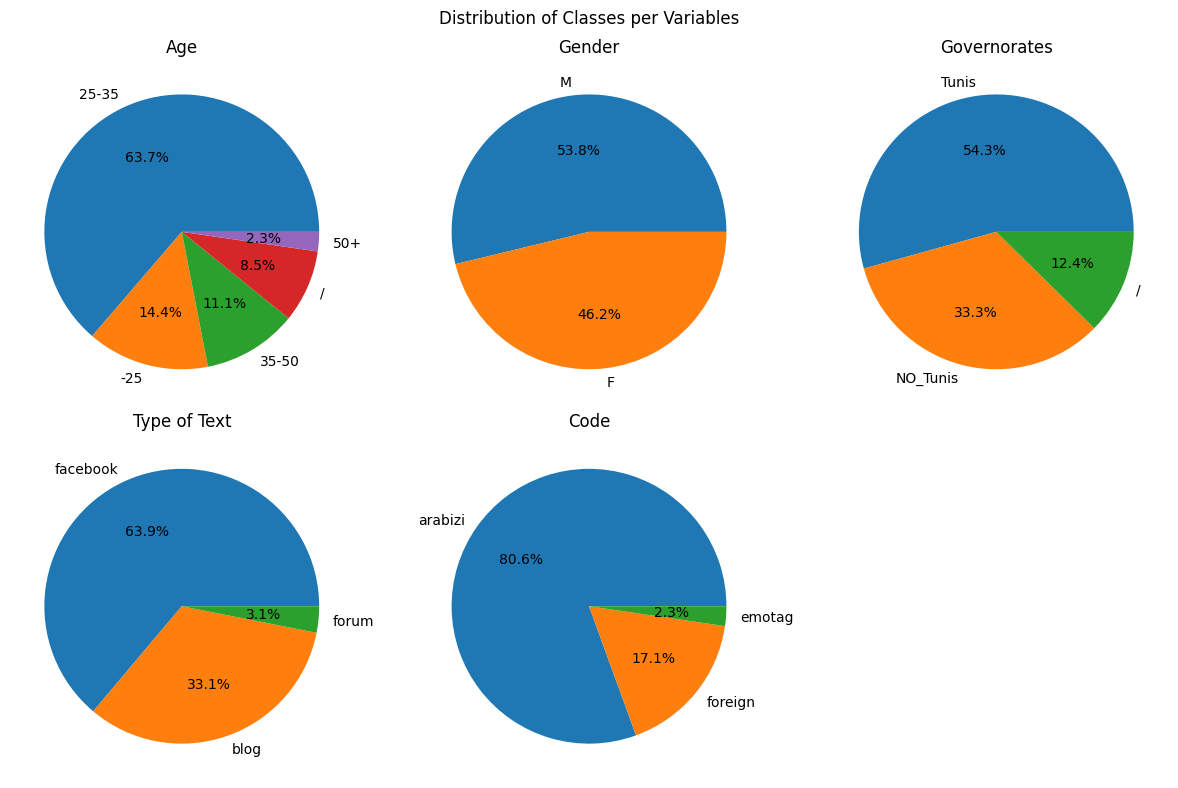

In [ ]:
# Creazione del grafico a torta per tutte le variabili
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Distribution of Classes per Variables')

# Distribuzione della variabile 'AGE_RANGE'
age_counts = data['AGE_RANGE'].value_counts()
axs[0, 0].pie(age_counts.values, labels=age_counts.index, autopct='%1.1f%%')
axs[0, 0].set_title('Age')

# Distribuzione della variabile 'GENDER'
gender_counts = data['GENDER'].value_counts()
axs[0, 1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
axs[0, 1].set_title('Gender')

# Distribuzione della variabile 'GOVERNORATE'
gov_counts = data['GOVERNORATE'].value_counts()
axs[0, 2].pie(gov_counts.values, labels=gov_counts.index, autopct='%1.1f%%')
axs[0, 2].set_title('Governorates')

# Distribuzione della variabile 'TYPE'
type_counts = data['TYPE'].value_counts()
axs[1, 0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
axs[1, 0].set_title('Type of Text')

# Distribuzione della variabile 'CODE'
code_counts = data['CODE'].value_counts()
axs[1, 1].pie(code_counts.values, labels=code_counts.index, autopct='%1.1f%%')
axs[1, 1].set_title('Code')

# Rimuovi l'ultimo asse inutilizzato
fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()


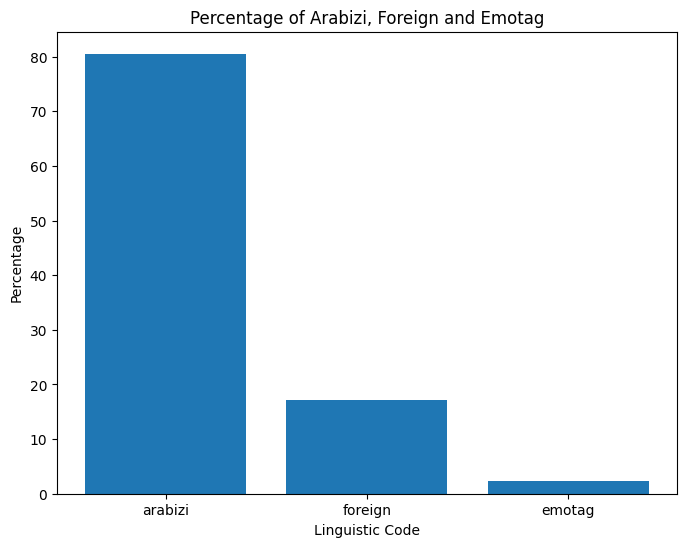

In [ ]:
# Creazione del grafico a barre per la variabile 'CODE'
code_labels = ['arabizi', 'foreign', 'emotag']
code_counts = data[data['CODE'].isin(code_labels)]['CODE'].value_counts()
code_percentages = code_counts / code_counts.sum() * 100

plt.figure(figsize=(8, 6))
plt.bar(code_labels, code_percentages)
plt.title('Percentage of Arabizi, Foreign and Emotag')
plt.xlabel('Linguistic Code')
plt.ylabel('Percentage')
plt.show()

In [ ]:
# INTEGRAZIONE POST-REVIEW
# Trasformazione della variabile CODE (target) in variabile binaria Vero/Falso, dove Vero è Foreign, mentre Falso è non-Foreign(ossia Arabizi-emotag)
mapping = {
    'foreign': True,
    'arabizi': False,
    'emotag': False
}

data['CODE'] = data['CODE'].replace(mapping)
data

,CODE,AGE_RANGE,GOVERNORATE,TYPE,GENDER
0,False,25-35,Tunis,forum,F
1,False,25-35,Tunis,forum,F
2,False,25-35,Tunis,forum,F
3,False,25-35,Tunis,forum,F
4,False,25-35,Tunis,forum,F
...,...,...,...,...,...
23350,True,25-35,Tunis,blog,M
23351,True,25-35,Tunis,blog,M
23352,True,25-35,Tunis,blog,M
23353,True,25-35,Tunis,blog,M


In [ ]:
# INTEGRAZIONE POST-REVIEW
# Encoding delle variabili categoriche eccetto la colonna target (CODE)
columns_to_encode = data.columns[data.columns != 'CODE']

# Il parametro drop_first è impostato su True in modo che la prima variabile dummy del livello non necessaria venga rimossa.
dataE = pd.get_dummies(data, columns=columns_to_encode)#, drop_first=True)
dataE.columns


Index(['CODE', 'AGE_RANGE_-25', 'AGE_RANGE_/', 'AGE_RANGE_25-35',
       'AGE_RANGE_35-50', 'AGE_RANGE_50+', 'GOVERNORATE_/',
       'GOVERNORATE_NO_Tunis', 'GOVERNORATE_Tunis', 'TYPE_blog',
       'TYPE_facebook', 'TYPE_forum', 'GENDER_F', 'GENDER_M'],
      dtype='object')

In [ ]:
# INTEGRAZIONE POST-REVIEW
# Suddivisione dei dati in set di addestramento e test
random_seed = 888
data_train, data_test = train_test_split(dataE, test_size=0.2, random_state=random_seed, stratify=data['CODE'])
#Il parametro "stratify" indica a scikit-learn di effettuare una suddivisione stratificata dei dati, ossia la colonna "CODE" viene utilizzata come base per suddividere i dati in modo che le proporzioni delle classi nella colonna "CODE" (il target) siano mantenute sia nel set di addestramento che in quello di test.

print(data_train.shape)
print(data_test.shape)
print()
print(data_train['CODE'].value_counts(normalize=True))
print()
print(data_test['CODE'].value_counts(normalize=True))
data_test

(16198, 14)
(4050, 14)

False    0.828683
True     0.171317
Name: CODE, dtype: float64

False    0.828642
True     0.171358
Name: CODE, dtype: float64


,CODE,AGE_RANGE_-25,AGE_RANGE_/,AGE_RANGE_25-35,AGE_RANGE_35-50,AGE_RANGE_50+,GOVERNORATE_/,GOVERNORATE_NO_Tunis,GOVERNORATE_Tunis,TYPE_blog,TYPE_facebook,TYPE_forum,GENDER_F,GENDER_M
5662,False,0,0,1,0,0,0,1,0,0,1,0,1,0
8614,False,0,0,1,0,0,0,0,1,1,0,0,1,0
13135,False,0,0,1,0,0,0,0,1,0,1,0,0,1
4329,False,0,0,1,0,0,0,1,0,0,1,0,1,0
23094,False,0,0,1,0,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,False,0,1,0,0,0,1,0,0,0,1,0,1,0
17957,False,0,0,1,0,0,0,1,0,0,1,0,0,1
20103,False,0,0,1,0,0,0,0,1,1,0,0,0,1
989,False,0,1,0,0,0,1,0,0,0,1,0,1,0


l'alta prevalenza della classe "False" rispetto alla classe "True" potrebbe influenzare le prestazioni del modello. In situazioni di sbilanciamento delle classi, il modello potrebbe tendere a predire maggiormente la classe maggioritaria e non essere altrettanto accurato nella predizione della classe minore.

Per affrontare il problema dello sbilanciamento delle classi, si possono adottare diverse tecniche, come l'oversampling della classe minore, l'undersampling della classe maggiore o l'utilizzo di algoritmi di classificazione progettati per gestire casi sbilanciati. Alcuni esempi di algoritmi progettati per classificazione sbilanciata includono:


*   Random Forest con peso di classe bilanciato
*   Logistic Regression con peso di classe bilanciato
*   Algoritmi di classificazione con campionamento di classe (es. SMOTE)

VEDI CELLA 31 PER ADDESTRAMENTO BILANCIATO

In [ ]:
# INTEGRAZIONE POST-REVIEW
# Separazione delle variabili indipendenti e dipendente
def get_features_and_target_arrays(data, independent_variables_cols):
    X = data[independent_variables_cols]#.to_numpy()
    #X = np.hstack(X)
    y = data['CODE']
    return X, y


independent_variables_cols = data_train.columns[dataE.columns != 'CODE']
X_train, y_train = get_features_and_target_arrays(data_train, independent_variables_cols)
X_test, y_test = get_features_and_target_arrays(data_test, independent_variables_cols)
X_train

,AGE_RANGE_-25,AGE_RANGE_/,AGE_RANGE_25-35,AGE_RANGE_35-50,AGE_RANGE_50+,GOVERNORATE_/,GOVERNORATE_NO_Tunis,GOVERNORATE_Tunis,TYPE_blog,TYPE_facebook,TYPE_forum,GENDER_F,GENDER_M
5540,0,1,0,0,0,0,1,0,0,1,0,1,0
13895,1,0,0,0,0,1,0,0,0,1,0,0,1
10308,0,0,1,0,0,0,0,1,1,0,0,1,0
16861,0,0,0,1,0,1,0,0,0,1,0,0,1
11429,0,0,1,0,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3026,0,0,1,0,0,0,0,1,0,1,0,1,0
15515,0,0,1,0,0,0,1,0,0,1,0,0,1
7625,0,0,1,0,0,0,0,1,1,0,0,1,0
22648,0,0,1,0,0,0,0,1,1,0,0,0,1


In [ ]:
print(data_train.shape)
print(data_test.shape)
print()
print(data_train['CODE'].value_counts(normalize=True))
print()
print(data_test['CODE'].value_counts(normalize=True))

(16198, 14)
(4050, 14)

False    0.828683
True     0.171317
Name: CODE, dtype: float64

False    0.828642
True     0.171358
Name: CODE, dtype: float64


In [ ]:
# Creazione e addestramento del modello di regressione logistica
model = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)
# l'algoritmo 'lbfgs', che sta per Limited-memory Broyden-Fletcher-Goldfarb-Shanno, è un algoritmo di ottimizzazione quasi-Newtoniano adatto per problemi di ottimizzazione di funzioni non vincolate. Questo solver è spesso utilizzato per problemi di regressione logistica multiclasse.


LogisticRegression(class_weight='balanced', multi_class='multinomial')

E' stato valutato l'uso dell'argomento class_weight nel costruttore del modello per specificare i pesi da assegnare alle diverse classi durante il calcolo della funzione di perdita, visto che i dati non sono bilanciati.
La scelta dei pesi dipende dalla distribuzione delle classi nel set di dati.

Senza l'argomento class_weight l'accuracy media del modello addestrato con la tecnica di cross-validation (vedi sotto) era dell'83%, mentre con i pesi delle classi bilanciate, scende al 71%. Questo valore, seppur inferiore costituisce un indice più affidabile delle prestazioni reali del modello.

Una conferma è fornita dalla matrice di confusione (vedi sotto), che prima del bilanciamento dei dati mostrava i seguenti risultati:

* True Negative (TN): 3332 campioni sono stati correttamente classificati come
"False" (assenza di CS).

* False Positive (FP): 24 campioni sono stati classificati erroneamente come "True" (presenza di CS) quando in realtà sono "Arabizi/Emotag".

* False Negative (FN): 677 campioni sono stati classificati erroneamente come "False" quando in realtà sono "Foreign".

* True Positive (TP): 17 campioni sono stati correttamente classificati come "True" (presenza di CS).

Invece, in seguito all'uso dell'argomento class_weight, la matrice riporta i seguenti risultati:

* True Negative (TN): 2434 campioni sono stati correttamente classificati come
"False" (assenza di CS).

* False Positive (FP): 922 campioni sono stati classificati erroneamente come "True" (presenza di CS) quando in realtà sono "Arabizi/Emotag".

* False Negative (FN): 259 campioni sono stati classificati erroneamente come "False" quando in realtà sono "Foreign".

* True Positive (TP): 435 campioni sono stati correttamente classificati come "True" (presenza di CS).

In [ ]:
# Esegui la cross-validation
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')

# Stampa i risultati
print("Accuracy media: {:.2f}".format(scores.mean()))
print("Deviazione standard: {:.2f}".format(scores.std()))

Accuracy media: 0.71
Deviazione standard: 0.01


È importante tenere presente che l'accuratezza da sola potrebbe non fornire una misura completa delle prestazioni del modello, specialmente se i dati sono sbilanciati o se ci sono classi con un numero molto ridotto di campioni. Pertanto, potresti voler considerare anche altre metriche di valutazione come la precisione, il richiamo, l'F1-score o l'area sotto la curva ROC per ottenere una valutazione più completa delle prestazioni del modello.

In [ ]:
# Valutazione del modello sul test-set
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))


              precision    recall  f1-score   support

       False       0.90      0.73      0.80      3356
        True       0.32      0.63      0.42       694

    accuracy                           0.71      4050
   macro avg       0.61      0.68      0.61      4050
weighted avg       0.80      0.71      0.74      4050



In [ ]:
# Creazione dell'istanza del modello di regressione logistica
lr = LogisticRegression(solver='newton-cg')

# Definizione del range per i pesi delle classi
weights = np.linspace(0.1, 0.9, 5)

# Creazione del dizionario per la griglia dei parametri
param_grid = {'class_weight': [{0: x, 1: 1.0 - x} for x in weights]}

# Esecuzione della Grid Search con 5 fold di validazione incrociata
gridsearch = GridSearchCV(estimator=lr,
                          param_grid=param_grid,
                          cv=StratifiedKFold(),
                          n_jobs=-1,
                          scoring='f1',
                          verbose=2)

# Addestramento del modello sulla griglia dei parametri
gridsearch.fit(X_train, y_train)

# Creazione del DataFrame per i risultati
weight_data = pd.DataFrame({'score': gridsearch.cv_results_['mean_test_score'],
                            'weight': (1 - weights)})


Fitting 5 folds for each of 5 candidates, totalling 25 fits


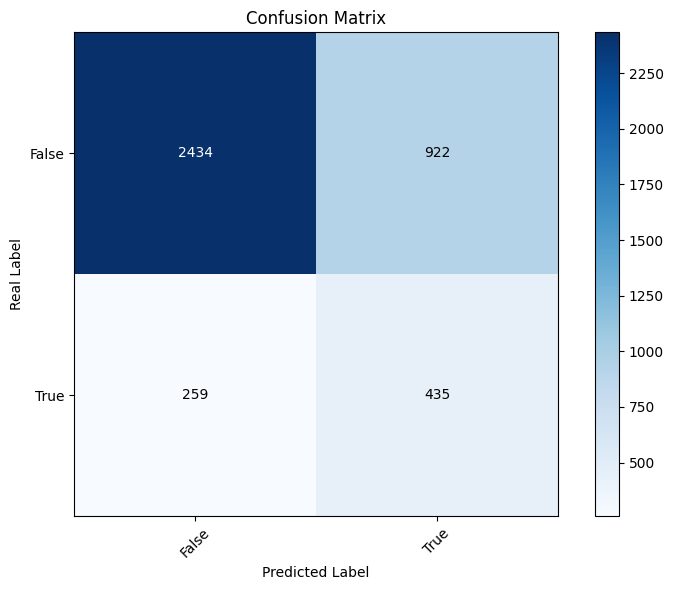

In [ ]:
# Calcola la matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Definisci le etichette delle classi
#class_labels = ['Falso', 'Vero']

# Estrai le etichette dalla variabile target (CODE)
class_labels = np.unique(np.concatenate((y_test, y_pred)))

# Crea il grafico della matrice di confusione
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('Real Label')

# Aggiungi i valori numerici alla matrice di confusione
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

**La matrice di confusione fornisce informazioni sulla correttezza delle previsioni del modello per ciascuna classe.**

1.   La prima riga rappresenta la classe reale "Arabizi/Emotag" (False).
2.   La seconda riga rappresenta la classe reale "Foreign" (True).

1.   La prima colonna rappresenta la classe predetta come "Arabizi/Emotag" (False).
2.   La seconda colonna rappresenta la classe predetta come "Foreign" (True).


Riguardo ai valori specifici all'interno della matrice:

* True Negative (TN): 2434 campioni sono stati correttamente classificati come
"False" (assenza di CS).

* False Positive (FP): 922 campioni sono stati classificati erroneamente come "True" (presenza di CS) quando in realtà sono "Arabizi/Emotag".

* False Negative (FN): 259 campioni sono stati classificati erroneamente come "False" quando in realtà sono "Foreign".

* True Positive (TP): 435 campioni sono stati correttamente classificati come "True" (presenza di CS).

*La mancanza di valori diversi da zero nelle predizioni errate per alcune classi può essere dovuta a un bilanciamento dei dati o a una mancanza di esempi rappresentativi per quelle classi nel set di dati utilizzato per la valutazione del modello.*

Accuratezza = (TN + TP) / (TN + FP + FN + TP)

In [ ]:
#Accuracy = (3332 + 17) / (3332 + 24 + 677 + 17) #PRE-REVIEW
Accuracy = (2434 + 435) / (2434 + 922 + 259 + 435)
Accuracy

0.7083950617283951

Class Labels: [False  True]

            Variable      coef   std err        t  P>|t|    [0.025    0.975]
       AGE_RANGE_-25 -0.559333 -0.195549 2.860315   0.00 -0.176056 -0.942610
         AGE_RANGE_/  0.187082  0.051883 3.605822   0.00  0.085391  0.288773
     AGE_RANGE_25-35 -0.070401 -0.033778 2.084218   0.04 -0.004196 -0.136607
     AGE_RANGE_35-50 -0.050794 -0.015913 3.191920   0.00 -0.019604 -0.081984
       AGE_RANGE_50+  0.457071  0.067744 6.747073   0.00  0.324293  0.589848
       GOVERNORATE_/ -0.406709 -0.133308 3.050890   0.00 -0.145425 -0.667993
GOVERNORATE_NO_Tunis  0.046810  0.022027 2.125122   0.03  0.003637  0.089982
   GOVERNORATE_Tunis  0.323524  0.161057 2.008747   0.04  0.007851  0.639196
           TYPE_blog -0.540655 -0.254781 2.122042   0.03 -0.041285 -1.040025
       TYPE_facebook  0.139240  0.066973 2.079045   0.04  0.007973  0.270507
          TYPE_forum  0.365039  0.062831 5.809884   0.00  0.241891  0.488187
            GENDER_F  0.267343  0.133325 2.0052

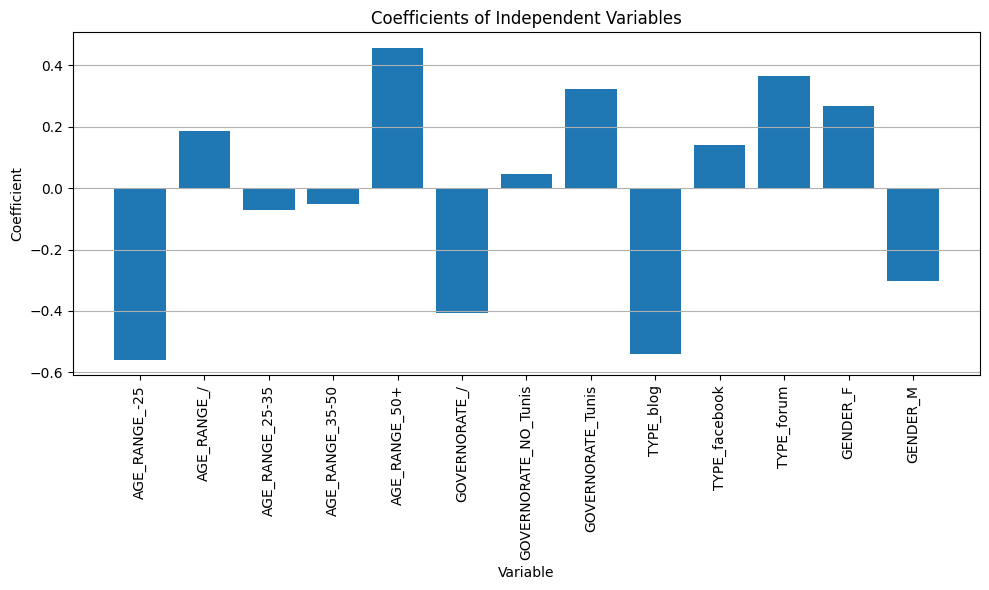

<Figure size 1200x600 with 0 Axes>

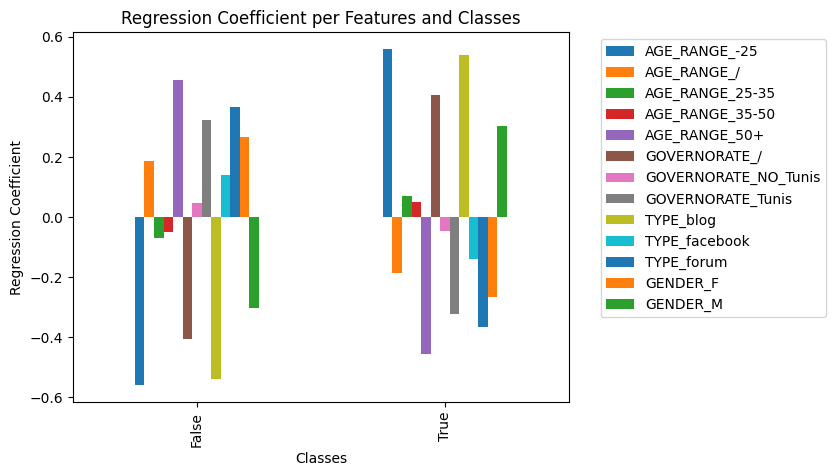

In [ ]:
class_labels = model.classes_
print(f"Class Labels: {class_labels}\n")

# Estrazione dei coefficienti di regressione
coefficients_false = model.coef_
coefficients_true = -coefficients_false

# Stampa i coefficienti per la classe True
# print("Coefficients for True (Class 1):", coefficients_true)
# print("Coefficients for False (Class 0):", coefficients_false)

# Estrai i coefficienti e il p-value dal modello
coefficients = model.coef_.ravel()
std_err = np.std(X_train, 0) * coefficients
t_or_z_values = coefficients / std_err
p_values = 2 * (1 - norm.cdf(abs(t_or_z_values)))

# Converti X_train in DataFrame per ottenere i nomi delle colonne
X_train_df = pd.DataFrame(X_train, columns=['AGE_RANGE_-25', 'AGE_RANGE_/', 'AGE_RANGE_25-35', 'AGE_RANGE_35-50', 'AGE_RANGE_50+', 'GOVERNORATE_/', 'GOVERNORATE_NO_Tunis', 'GOVERNORATE_Tunis', 'TYPE_blog', 'TYPE_facebook', 'TYPE_forum', 'GENDER_F', 'GENDER_M'])


# Crea una tabella per i risultati
result_table = pd.DataFrame({
    'Variable': X_train_df.columns,
    'coef': coefficients,
    'std err': std_err,
    't': t_or_z_values,
    'P>|t|': p_values,
    '[0.025': coefficients - 1.96 * std_err,
    '0.975]': coefficients + 1.96 * std_err
})

result_table['P>|t|'] = result_table['P>|t|'].apply(lambda x: round(x, 2))
print(result_table.to_string(index=False))

# Plot dei coefficienti
plt.figure(figsize=(10, 6))
plt.bar(result_table['Variable'], result_table['coef'])
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.title('Coefficients of Independent Variables')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Estrai i nomi delle colonne/features dal DataFrame data_train
feature_names = data_train.drop('CODE', axis=1).columns

# Crea un DataFrame dai coefficienti di regressione per entrambe le classi
coefficients_df = pd.DataFrame(np.vstack([coefficients_false, coefficients_true]), columns=feature_names, index=['False', 'True'])

# Plot dei coefficienti come grafico a doppia barra (bar chart)
plt.figure(figsize=(12, 6))
coefficients_df.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Regression Coefficient')
plt.title('Regression Coefficient per Features and Classes')
#plt.legend(loc='best')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

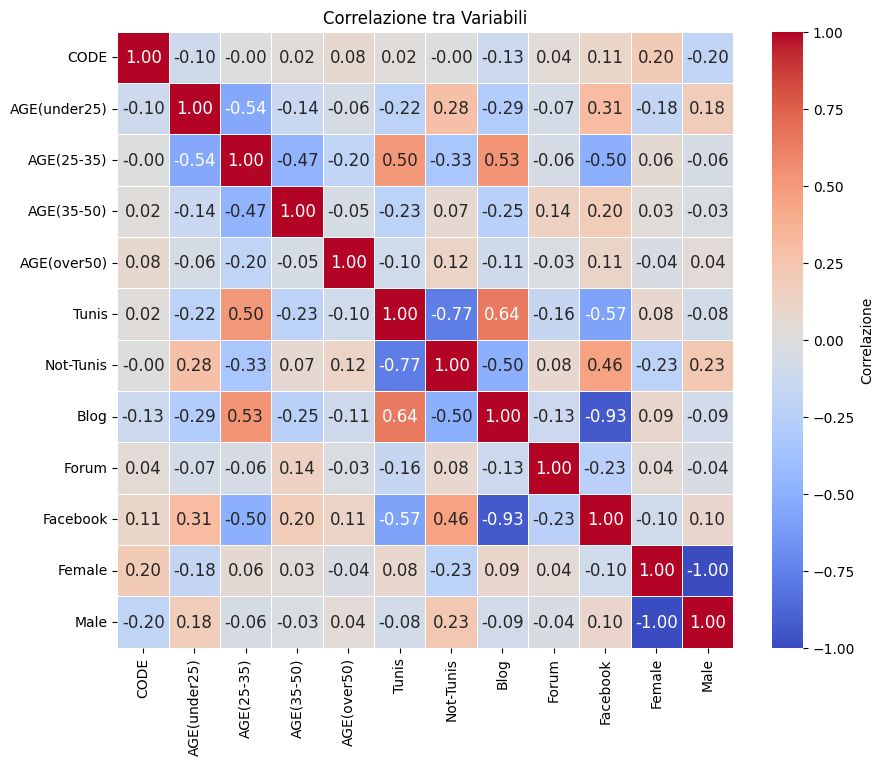

In [ ]:
#HEATMAP

# Crea un DataFrame con le variabili indipendenti e dipendenti
data = pd.DataFrame({
    'CODE': y_train,
    'AGE(under25)': X_train_df['AGE_RANGE_-25'],
    'AGE(25-35)': X_train_df['AGE_RANGE_25-35'],
    'AGE(35-50)': X_train_df['AGE_RANGE_35-50'],
    'AGE(over50)': X_train_df['AGE_RANGE_50+'],
    'Tunis': X_train_df['GOVERNORATE_Tunis'],
    'Not-Tunis': X_train_df['GOVERNORATE_NO_Tunis'],
    'Blog': X_train_df['TYPE_blog'],
    'Forum': X_train_df['TYPE_forum'],
    'Facebook': X_train_df['TYPE_facebook'],
    'Female': X_train_df['GENDER_F'],
    'Male': X_train_df['GENDER_M']
})

# Calcola la matrice di correlazione
corr_matrix = data.corr()

# Crea il grafico della heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            cbar=True, square=True, annot_kws={"size": 12},
            xticklabels=data.columns, yticklabels=data.columns,
            cbar_kws={'label': 'Correlazione'})


plt.title('Correlazione tra Variabili')
plt.show()


Contingency Table between GENDER and CODE:
CODE    False  True    All
GENDER                    
F        6998  2362   9360
M        9781  1107  10888
All     16779  3469  20248



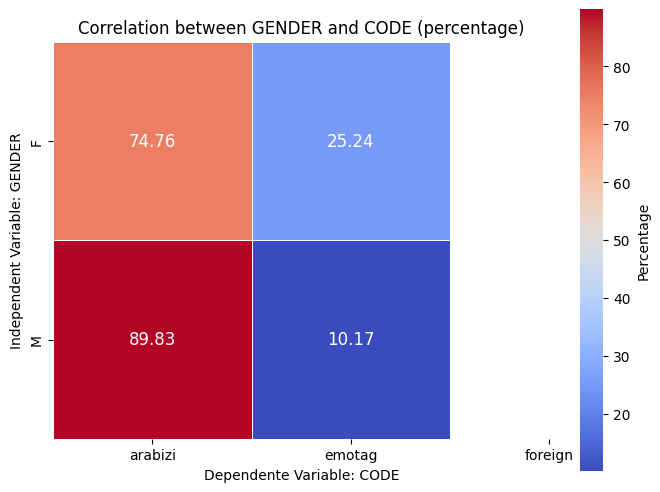

In [ ]:
# Mappa delle classi per la variabile 'CODE'
classi_code = ['arabizi', 'emotag', 'foreign']

# Mappa delle classi per la variabile 'GENDER'
classi_gender = ['F', 'M']

# Calcola la tabella di contingenza tra 'GENDER' e 'CODE'
contingency_table = pd.crosstab(dataOriginal['GENDER'], dataOriginal['CODE'], margins=True)

# Calcola la tabella di contingenza normalizzata in percentuale
normalized_contingency = contingency_table.apply(lambda x: x / x.loc['All'] * 100, axis=1)

# Stampa la tabella di contingenza con i totali
print("Contingency Table between GENDER and CODE:")
print(contingency_table)
print()

# Rimuovi la riga e colonna dei totali per il calcolo della heatmap
normalized_contingency = normalized_contingency.iloc[:-1, :-1]

# Crea il grafico della heatmap per 'GENDER' e 'CODE' con i valori normalizzati
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_contingency, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            cbar=True, square=True, annot_kws={"size": 12},
            xticklabels=classi_code, yticklabels=classi_gender,
            cbar_kws={'label': 'Percentage'})


plt.title('Correlation between GENDER and CODE (percentage)')
plt.xlabel('Dependente Variable: CODE')
plt.ylabel('Independent Variable: GENDER')
plt.show()


Nel codice sopra, ho calcolato la tabella di contingenza normalizzata utilizzando div() per dividere ogni valore della tabella di contingenza per la somma totale di tutti i valori. Poi, ho utilizzato i valori normalizzati nella heatmap, specificando fmt=".2%" per formattare i valori come percentuali con due decimali.

Contingency Table between AGE RANGE and CODE:
CODE       False  True    All
AGE_RANGE                    
-25         2692   215   2907
/           1292   439   1731
25-35      10691  2207  12898
35-50       1810   440   2250
50+          294   168    462
All        16779  3469  20248



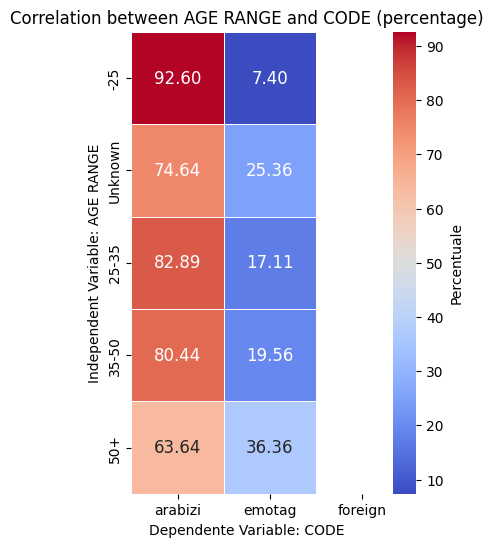

In [ ]:
# Mappa delle classi per la variabile 'CODE'
classi_code = ['arabizi', 'emotag', 'foreign']

# Mappa delle classi per la variabile 'AGE_RANGE'
classi_age = ['-25', 'Unknown', '25-35', '35-50', '50+']

# Calcola la tabella di contingenza tra 'AGE_RANGE' e 'CODE'
contingency_table = pd.crosstab(dataOriginal['AGE_RANGE'], dataOriginal['CODE'], margins=True)

# Calcola la tabella di contingenza normalizzata in percentuale
normalized_contingency = contingency_table.apply(lambda x: x / x.loc['All'] * 100, axis=1)

# Stampa la tabella di contingenza con i totali
print("Contingency Table between AGE RANGE and CODE:")
print(contingency_table)
print()

# Rimuovi la riga e colonna dei totali per il calcolo della heatmap
normalized_contingency = normalized_contingency.iloc[:-1, :-1]

# Crea il grafico della heatmap per 'AGE_RANGE' e 'CODE' con i valori normalizzati
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_contingency, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            cbar=True, square=True, annot_kws={"size": 12},
            xticklabels=classi_code, yticklabels=classi_age,
            cbar_kws={'label': 'Percentuale'})

plt.title('Correlation between AGE RANGE and CODE (percentage)')
plt.xlabel('Dependente Variable: CODE')
plt.ylabel('Independent Variable: AGE RANGE')
plt.show()


Contingency Table between GOVERNORATE and CODE:
CODE         False  True    All
GOVERNORATE                    
/             2162   341   2503
NO_Tunis      5607  1142   6749
Tunis         9010  1986  10996
All          16779  3469  20248



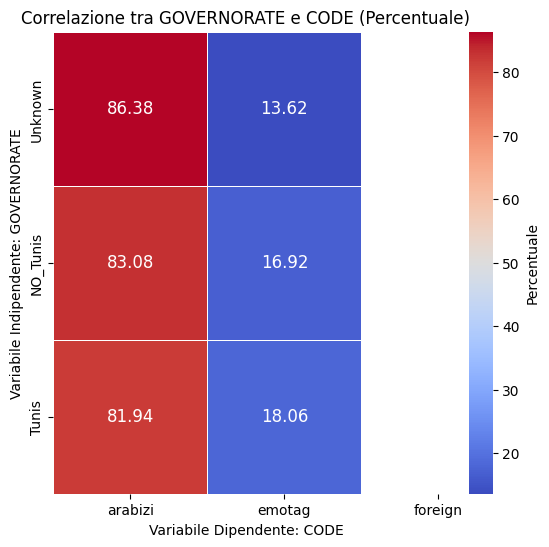

In [ ]:
# Mappa delle classi per la variabile 'CODE'
classi_code = ['arabizi', 'emotag', 'foreign']

# Mappa delle classi per la variabile 'GOVERNORATE'
classi_gov = ['Unknown', 'NO_Tunis', 'Tunis']

# Calcola la tabella di contingenza tra 'GOVERNORATE' e 'CODE'
contingency_table = pd.crosstab(dataOriginal['GOVERNORATE'], dataOriginal['CODE'], margins=True)

# Calcola la tabella di contingenza normalizzata in percentuale
normalized_contingency = contingency_table.apply(lambda x: x / x.loc['All'] * 100, axis=1)

# Stampa la tabella di contingenza con i totali
print("Contingency Table between GOVERNORATE and CODE:")
print(contingency_table)
print()

# Rimuovi la riga e colonna dei totali per il calcolo della heatmap
normalized_contingency = normalized_contingency.iloc[:-1, :-1]

# Crea il grafico della heatmap per 'GOVERNORATE' e 'CODE' con i valori normalizzati
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_contingency, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            cbar=True, square=True, annot_kws={"size": 12},
            xticklabels=classi_code, yticklabels=classi_gov,
            cbar_kws={'label': 'Percentuale'})

plt.title('Correlazione tra GOVERNORATE e CODE (Percentuale)')
plt.xlabel('Variabile Dipendente: CODE')
plt.ylabel('Variabile Indipendente: GOVERNORATE')
plt.show()

Contingency Table between TYPE and CODE:
CODE      False  True    All
TYPE                        
blog       5985   707   6692
facebook  10334  2595  12929
forum       460   167    627
All       16779  3469  20248



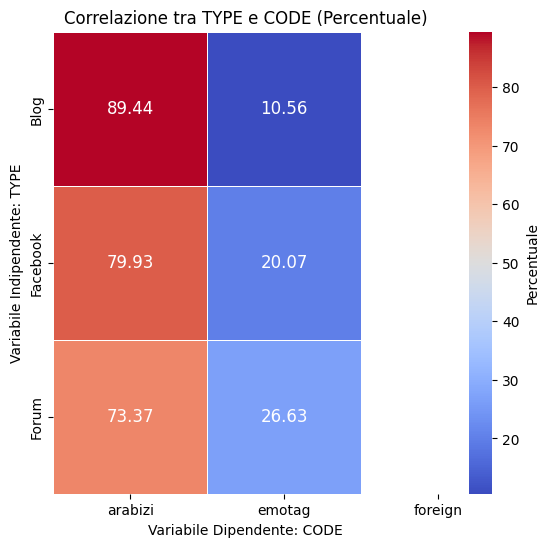

In [ ]:
# Mappa delle classi per la variabile 'CODE'
classi_code = ['arabizi', 'emotag', 'foreign']

# Mappa delle classi per la variabile 'TYPE'
classi_typ = ['Blog', 'Facebook', 'Forum']

# Calcola la tabella di contingenza tra 'TYPE' e 'CODE'
contingency_table = pd.crosstab(dataOriginal['TYPE'], dataOriginal['CODE'], margins=True)

# Calcola la tabella di contingenza normalizzata in percentuale
normalized_contingency = contingency_table.apply(lambda x: x / x.loc['All'] * 100, axis=1)

# Stampa la tabella di contingenza con i totali
print("Contingency Table between TYPE and CODE:")
print(contingency_table)
print()

# Rimuovi la riga e colonna dei totali per il calcolo della heatmap
normalized_contingency = normalized_contingency.iloc[:-1, :-1]

# Crea il grafico della heatmap per 'TYPE' e 'CODE' con i valori normalizzati
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_contingency, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            cbar=True, square=True, annot_kws={"size": 12},
            xticklabels=classi_code, yticklabels=classi_typ,
            cbar_kws={'label': 'Percentuale'})

plt.title('Correlazione tra TYPE e CODE (Percentuale)')
plt.xlabel('Variabile Dipendente: CODE')
plt.ylabel('Variabile Indipendente: TYPE')
plt.show()

